<a href="https://colab.research.google.com/github/andrescorp93/ArHe_collision_spectrum/blob/master/Test_Buckingham_Van_der_Waals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np
from scipy.special import kn, gamma
from scipy.integrate import simps
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

mu = 3.63 # reduced mass for Ar-He
R = 8.31E7 # gas constant
angtocm = 1e-8
c = 2.998e10
cm1tos1 = 2 * np.pi * c

In [ ]:
def u(r, u0, A, alpha, C6, C8):
    uex = A * np.exp(-alpha*r)
    u6 = C6 * np.power(r, -6)
    u8 = C8 * np.power(r, -8)
    return u0 + uex + u6 + u8
    
    
def buckingham_phase(r, v, A, alpha):
    A *= cm1tos1
    return 2*A*r*kn(1, r)*angtocm / v


def power_integral(r, n):
    k = np.sqrt(np.pi)*gamma((n-1)/2)/gamma(n/2)
    return np.power(r, 1-n)*k


def van_der_waals_phase(r, v, C6, C8):
    C6 *= cm1tos1
    C8 *= cm1tos1
    phi6 = power_integral(r, 6) * C6
    phi8 = power_integral(r, 8) * C8
    return (phi6+phi8)*angtocm / v


def phase_shift(r, v, low, up):
    buckinghampart = buckingham_phase(r, v, up["A"], up["alpha"]) - buckingham_phase(r, v, low["A"], low["alpha"])
    vanderwaalspart = van_der_waals_phase(r, v, up["C6"], up["C8"]) - van_der_waals_phase(r, v, low["C6"], low["C8"])
    return buckinghampart + vanderwaalspart


def cross(v, low, up):
    
    #return sigmab, sigmas
    pass


def maxwell(v, T):
    """
    Maxwell distribution
    v - velocity, cm/s
    T - temperature, K
    norm - coefficient of normalization
    """
    norm = ((mu / (2 * np.pi * R * T)) ** 1.5)
    return 4 * np.pi * (v ** 2) * norm * np.exp(-mu * v ** 2 / (2 * R * T))


def calc_coeffs(T, low, up):
    r = np.arange(4.5, 20, 0.002)
    v = np.arange(1e3, 7e5, 5e2)
    sigmab = np.zeros(len(v))
    sigmas = np.zeros(len(v))
    phaseshift = phase_shift(r, 1000, low, up) * 1000
    for i in range(len(v)):
        sigmab[i] = simps(r*(1-np.cos(phaseshift/v[i])), r) * angtocm**2
        sigmas[i] = simps(r*(np.sin(phaseshift/v[i])), r) * angtocm**2
    kb = simps(sigmab*v*maxwell(v, T), v)
    ks = simps(sigmas*v*maxwell(v, T), v)
    return kb, ks


def lorentz(w, A, s, b, h = 0):
    """
    Lorentz spectrum function
    """

    return b * A / ( np.pi * ((w - s) ** 2 + b ** 2)) + h

In [ ]:
drive.mount('/content/gdrive')
with open('/content/gdrive/My Drive/Colab Notebooks/energy_2.txt') as energy_file:
    energy_txt = [line.strip().split("\t") for line in energy_file.readlines()]
    energies = {energy_txt[0][i]: np.array([float(energy_txt[k][i]) for k in range(1, len(energy_txt))])
                for i in range(len(energy_txt[0]))}

coeffs = {}
for k, v in energies.items():
    if k != 'R':
        popt, pcov = curve_fit(u, energies['R'], v, p0=[93121.93235865, 56137.38381428, 1.17929563238, -1868306.050444, 14555639.94703])
        res = {'u0': popt[0], 'A': popt[1], 'alpha': popt[2], 'C6': popt[3], 'C8': popt[4]}
        coeffs[k] = res

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
r = energies['R']
b = energies['R']
v = np.arange(1e4,1e6,1e4)
#plt.plot(energies['R'], energies['1A1'], 'r+')
transitions = ['4A1_1A1', '4A1_1B1', '5B1_1B1', '6B1_1A1', '4A1_1B2', '5B2_1B2',
               '6B2_1A1', '5B1_1A2', '6B1_1A2', '5B2_1A2', '6B2_1A2', '5B1_2A2',
               '5B2_2A2', '5A2_1B1', '5A2_1B2', '5A2_1A2', '6A2_1B1', '6A2_1B2',
               '6A2_2A2']
intens = [26.68624287823664, 23.70996861374172, 37.54476650061099,
          38.49686632505806, 23.709990642469705, 37.54476369743072,
          38.49688524839909, 3.773954804766042, 35.23191176441894,
          3.7750743050586917, 35.23157866799139, 32.036164771103685,
          32.03507062151925, 23.886646851098053, 23.88643965740735,
          26.383726401496105, 15.123505682636436, 15.123714629832458,
          44.0001649807547]
temp = np.array([300+50*i for i in range(18)])
results = {'T': temp}
for t in transitions:
    ups, lows = tuple(t.split('_'))
    low1 = coeffs[lows]
    up1 = coeffs[ups]
    freq = (energies[ups] - energies[lows] - energies[ups][0] + energies[lows][0]) * cm1tos1
    shifts = np.zeros(len(v))
    broads = np.zeros(len(v))
    for k in range(len(v)):
        E0 = mu * 1.66e-24 * v[k]**2 / 2
        result = np.zeros(len(b))
        for i in range(len(b)): 
            u_approx = (energies[lows] - energies[lows][0]) * 3.17e-17  + E0 * (b[i]/r)**2
            v_inversed = np.zeros(len(u_approx))
            for j in range(len(u_approx)):
                if u_approx[j] >= E0:
                    u_approx[j] = 0
                else:
                    v_inversed[j] = 1/np.sqrt((2 / (mu*1.66e-24)) * (E0 - u_approx[j]))
            result[i] = simps(freq * v_inversed, r * angtocm)
        broads[k] = simps(2*np.pi*b*(1-np.cos(result))*angtocm, b*angtocm)
        shifts[k] = simps(2*np.pi*b*np.sin(result)*angtocm, b*angtocm)
    k_s = np.zeros(len(temp))
    k_b = np.zeros(len(temp))
    for i in range(len(temp)):
        k_s[i] = simps(v*shifts*maxwell(v, temp[i]), v)
        k_b[i] = simps(v*broads*maxwell(v, temp[i]), v)
    results[t] = {'shifts': k_s, 'broads': k_b, 'w0': (energies[ups][0] - energies[lows][0]) * cm1tos1, 'I0': intens[transitions.index(t)]}
#print(results)

In [ ]:
w_mean = sum([results[k]['w0'] for k in transitions])/len(transitions)
print([results[k]['w0'] - w_mean for k in transitions])

[-508280185617955.75, 35925294973270.5, 574386660684129.2, -484915934266961.25, 35925294973270.5, 574386660684129.2, -484916761116617.25, 30181180092903.0, -484915934266961.25, 30181180092903.0, -484916761116617.25, 576638995342921.8, 576638995342921.8, 35962916566705.25, 35962916566705.25, -508242564024521.25, 149248570143658.0, 149248570143658.0, 151500904802450.5]


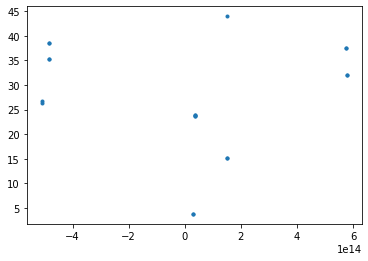

In [ ]:
plt.plot(np.array([results[k]['w0'] - w_mean for k in transitions]), np.array(intens), '.')
plt.show()

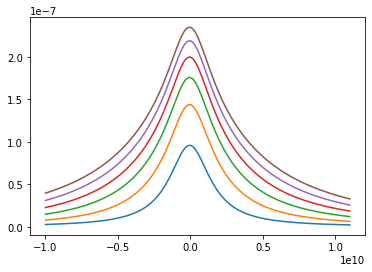

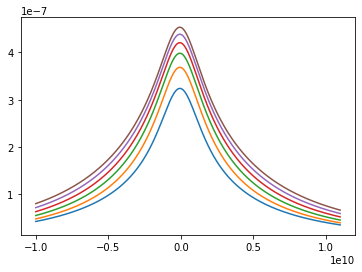

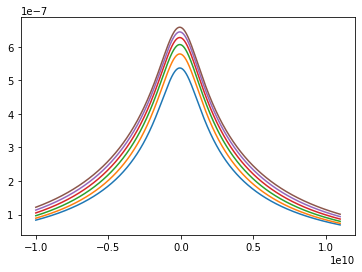

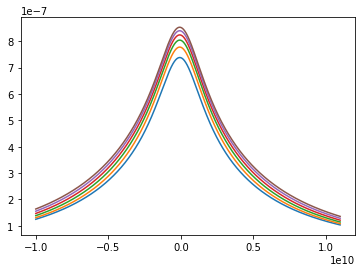

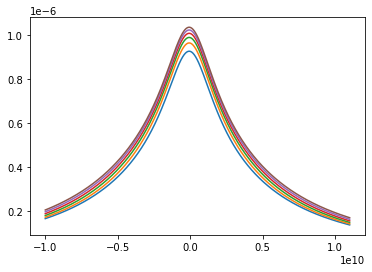

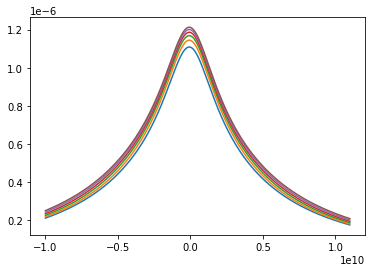

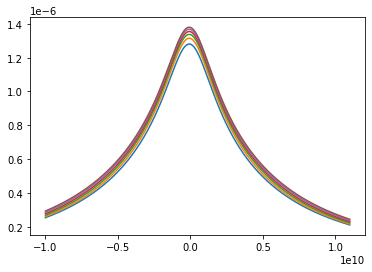

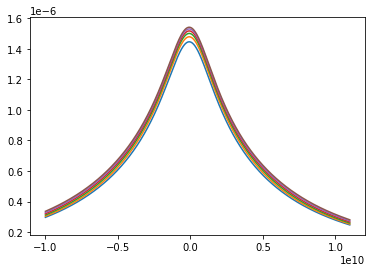

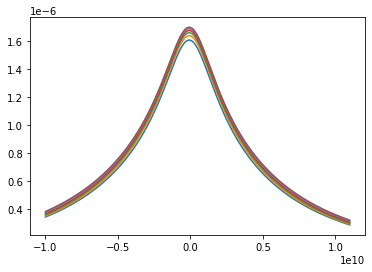

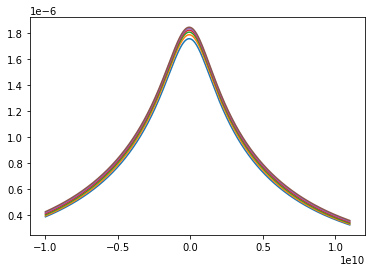

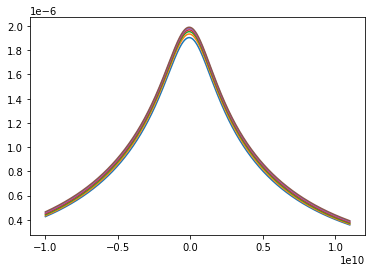

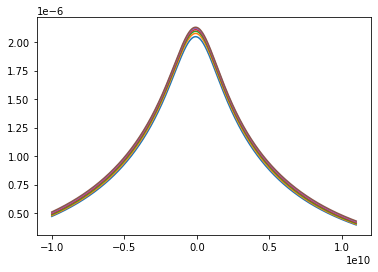

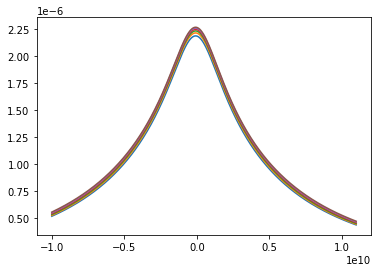

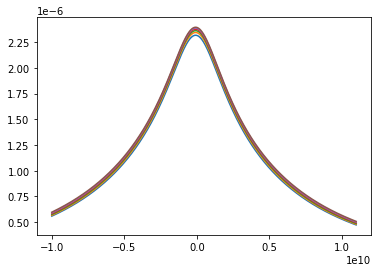

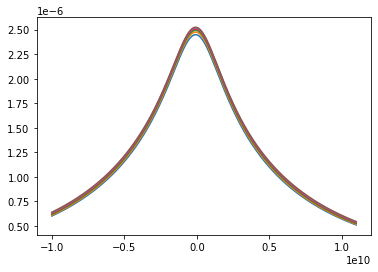

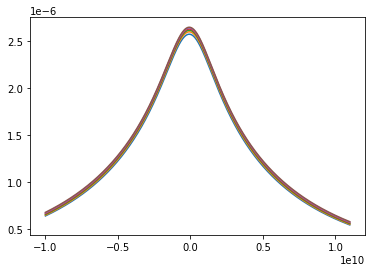

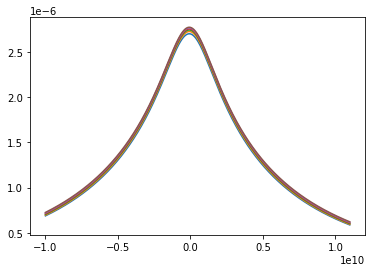

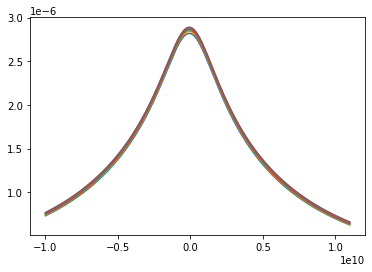

In [ ]:
omega = np.arange(-1e10, 1.1e10, 1e7)
concentrations = np.arange(5e17, 3.5e18, 5e17)
spectrum = np.zeros(len(omega))
for i in range(len(temp)):
    for n in concentrations:
        for t, v in results.items():
            if t != 'T':
                spectrum += np.array([lorentz(w, v['I0'], v['shifts'][i] * n, v['broads'][i] * n) for w in omega])
        plt.plot(omega, spectrum)
    plt.show()